<a href="https://colab.research.google.com/github/RonnyGuevara/Fractal_Images/blob/main/TP1/TP1_FI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 1:  Box counting

##Presentado por: Ronny Guevara

## Objetivo General
Implementar el método de estimación numérica de dimensiones fractales  
## Objetivos Específicos
*   Construir un aplicativo que permita estimar la dimensión fractal de un objeto
*   Visualización de resultados en una interfaz amigable con el usuario

## Descripción del práctico:
Las actividades propuestas son:

*   Ubicar la imagen binaria en un viewport
*   Subdividir el viewport en cajas de tamaño 1, 1/2, 1/4 etc. del viewport (hasta llegar al tamaño del pixel)
*   Contar la cantidad de cajas tocadas por el conjunto (promediado traslaciones)
*   Computar D como la pendiente de la recta de ajuste en el espacio log-log





In [1]:
#Librerías a utilizar
import imageio as io
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab as pl
import pandas as pd

In [2]:
#Función que permite leer una imagen sin limitación de UNIT8
def get_image(dir):
  image = io.imread(dir)
  image = image.astype(np.int64)
  return image

#Función que permite plotear la imagen
def plot2_image(image,Imagen, cmap=None):
  plt.figure(figsize=(100,100)) 
  plt.figure()
  plt.title(Imagen)
  plt.imshow(image,cmap=cmap)
  plt.colorbar()
  plt.grid(False)
  plt.show()

#Copia de la imagen Original
def image_copy(image):
  work_image=np.copy(image)
  return work_image 

#Información de la imagen
def image_info(image):
  print('This image is', image.dtype)
  print('with dimensions', image.shape)

#Normalización de las imágenes
def image_norm(image):
  norm=image.astype(np.float64)/255
  return norm

#Conversión RGB2YIQ
def image_RGB2YIQ(image):
  matrixYIQ=np.array([[0.299,0.587,0.144],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
  YIQ=np.dot(image,matrixYIQ)
  y = YIQ[:,:,0]
  i = YIQ[:,:,1]
  q = YIQ[:,:,2]
  y = np.clip(y, 0 ,1)
  q = np.clip(q,-0.5957 , 0.5957 )
  i = np.clip(i, -0.5226 , 0.5226) 
  return y, i, q

#Construcción de la imagen a partir de las componentes YIQ
def yiq_to_image(y,i,q):
  Shape = y.shape
  im_out = np.zeros((Shape[0], Shape[1], 3))
  im_out[:,:,0] = y
  im_out[:,:,1] = i
  im_out[:,:,2] = q
  return im_out.astype(np.float64)
  
#Conversión YIQ2RGB
def image_YIQ2RGB(image):
  matrixRGB=np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
  RGB=np.dot(image,matrixRGB)
  RGB=RGB.clip(0,1)*255
  RGB=RGB.astype(np.uint8)
  return RGB

In [3]:
def padding(im1):

  im1_new = np.ones((512, 512, 3), dtype='float')
  for i in range(512):
    for j in range(512):
      im1_new [i,j] = im1 [i, j]
  
  return im1_new

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 7200x7200 with 0 Axes>

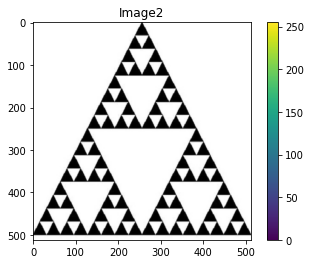

In [5]:
#@title Selecciona la imagen { run: "auto" }
Image1='/content/drive/MyDrive/Colab Notebooks/FRACTAL1.jpg'
Image2='/content/drive/MyDrive/Colab Notebooks/FRACTAL2.jpg'
Image3='/content/drive/MyDrive/Colab Notebooks/FRACTAL3.jpg'
Image4='/content/drive/MyDrive/Colab Notebooks/FRACTAL4.jpg'
Imagen = 'Image2' #@param ["Image1", "Image2", "Image3", "Image4"]

if Imagen == 'Image1':
  image = get_image(Image1)
  plot2_image(image, 'Image1')
elif Imagen == 'Image2':
  image = get_image(Image2)
  plot2_image(image, 'Image2')
elif Imagen == 'Image3':
  image = get_image(Image3)
  plot2_image(image, 'Image3')
elif Imagen == 'Image4':
  image = get_image(Image4)
  plot2_image(image, 'Image4')

In [6]:
#Proceso de copia de la imagen 
#Limitación del tamaño de la imagen (512*512)
#Visualización de información
work_image=image_copy(image)
work_image=padding(work_image)
image_info(work_image)

This image is float64
with dimensions (512, 512, 3)


<Figure size 7200x7200 with 0 Axes>

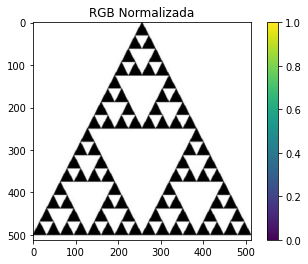

In [7]:
#Normalización de la imagen
work_image=image_norm(work_image)
plot2_image(work_image,'RGB Normalizada',cmap=None)

<Figure size 7200x7200 with 0 Axes>

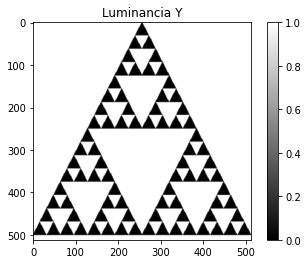

This image is float64
with dimensions (512, 512)


In [8]:
#Conversión del espacio RGB a YIQ
y, i, q = image_RGB2YIQ(work_image)
plot2_image(y,'Luminancia Y',cmap='gray')
image_info(y)

In [9]:
#Dimensión de la imagen
Lx=image.shape[1]
Ly=image.shape[0]

In [10]:
# Conteo de los píxeles distintos de cero
pixels=[]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if y[i,j]<1:
            pixels.append((i,j))

pixels=np.array(pixels)
print (pixels.shape)

(50572, 2)


<Figure size 7200x7200 with 0 Axes>

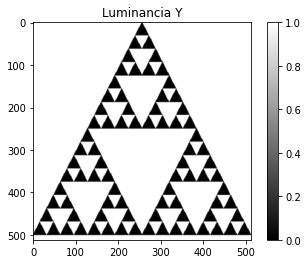

   Reg  Log(Reg)  Media  Log(Media)
0  256 -0.616901  15807    9.668208
1  128 -0.540655  18466    9.823686
2   64 -0.464409  21268    9.964959
3   32 -0.388162  24487   10.105898
4   16 -0.311916  28338   10.251959
5    8 -0.235670  32652   10.393661
6    4 -0.159424  37453   10.530842
7    2 -0.083178  43546   10.681573
8    1 -0.006931  49855   10.816874


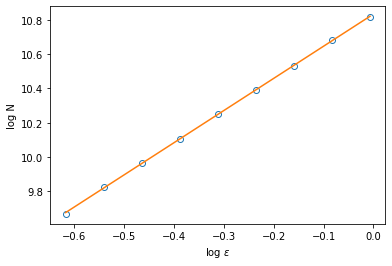

Dimensión de Hausdorff 1.8772203104884582


In [11]:
# Cálculo de la dimensión fractal
scales=np.logspace(0.01, 1, num=9, endpoint=False, base=2)
Ns=[]
logx, logy = ([], [])
logx=[]
logx.append(0)
scale=[]
# Conteo de pixels en cada división del histograma
for scale in scales:
    H, edges=np.histogramdd(pixels, bins=(np.arange(0,Lx,scale),np.arange(0,Ly,scale)))
    Ns.append(np.sum(H>0))
    logx.append(np.log(1/scale))
 
coeffs=np.polyfit(np.log(scales), np.log(Ns), 1)
plot2_image(y,'Luminancia Y',cmap='gray')
pl.plot(np.log(1/scales),np.log(Ns), 'o', mfc='none')
pl.plot(np.log(1/scales), np.polyval(coeffs,np.log(scales)))
pl.xlabel('log $\epsilon$')
pl.ylabel('log N')
logy=(np.log(Ns))
logx.pop(0)
logy.sort()
logx.sort()
Ns.sort()
Region=[256, 128, 64, 32, 16, 8, 4, 2, 1]
df=pd.DataFrame({'Reg':Region,
                 'Log(Reg)':logx ,
                 'Media':Ns ,
                 'Log(Media)':logy})

print (df)
plt.show()
print ("Dimensión de Hausdorff", -coeffs[0])

###Análisis de resultados

*    El trabajo práctico desarrollado permite al usuario seleccionar una imagen, limitar su tamaño a 512 * 512 pixeles, para posterior normalizarla y trasladarla al espacio YIQ. Al trabajar con la luminancia se obtiene un conteo de los pixeles distintos a 0, se implementa box counting mediante un histograma de tamaños de contenedores variables.
*   La dimensión de Hausdorff es obtenida usando la función polyfit que devuelve el ajuste polinomial de los mínimos cuadrados del logaritmo de la región y el logaritmo de la media.
*   El aplicativo permite computar la pendiente de la recta de ajuste en el espacio log – log.